# Análise dos Erros dos Modelos

Nesta etapa iremos verificar o quão siginificante são os erros que o modelo de Random Forest obteve e se existem informações ainda possíveis de serem extraídas.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [8]:
df = pd.read_csv("dados_ajustes.csv", header=0)
df.head()

,Selling_Price,Present_Price,Fuel_Type_Diesel,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Seller_Type_Dealer,Seller_Type_Individual,Novo,Usado,...,30k-40k,40k-50k,50k-60k,60k-70k,70k-80k,80k-90k,90k-100k,100k-110k,110k-120k,120k-300k
0,3.35,5.59,0,1,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,4.75,9.54,1,0,0,1,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,7.25,9.85,0,1,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2.85,4.15,0,1,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4.60,6.87,1,0,0,1,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [9]:
data = df.to_numpy()
nrow, ncol = data.shape

X = data[:, 1:ncol]
y = data[:,0]

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

rf = RandomForestRegressor(n_estimators=60, random_state=30)
poly_rg = PolynomialFeatures(degree=5)
ridge = Ridge()

x_poly = poly_rg.fit_transform(x_train)
x_poly_test = poly_rg.fit_transform(x_test)

model_rf = rf.fit(x_train,y_train)
model_poly = ridge.fit(x_poly, y_train)

y_pred_rf = model_rf.predict(x_test)
y_pred_poly = model_poly.predict(x_poly_test)

score_rf = r2_score(y_test, y_pred_rf)
score_poly = r2_score(y_test, y_pred_poly)

score_rf2 = mean_absolute_error(y_test, y_pred_rf)
score_poly2 = mean_absolute_error(y_test, y_pred_poly)

print("Variabilidade do Random Forest", score_rf)
print("Média dos Erro Absolutos dos dados", score_rf2, "para uma média de preços de", np.mean(y_test))
print('')
print("Variabilidade do Polinomial Regression", score_poly)
print("Média dos Erro Absolutos dos dados", score_poly2, "para uma média de preços de", np.mean(y_test))

Variabilidade do Random Forest 0.9644860986076739
Média dos Erro Absolutos dos dados 0.6119366534391534 para uma média de preços de 5.078333333333333

Variabilidade do Polinomial Regression 0.9557071059235955
Média dos Erro Absolutos dos dados 0.7295564441625316 para uma média de preços de 5.078333333333333


Quando analisamos a média dos erros com a média dos preços vemos que ainda há uma variação grande, podemos construir um gráfico de predição x dados, para analisar se talvez esses números sejam inflados por excessões.

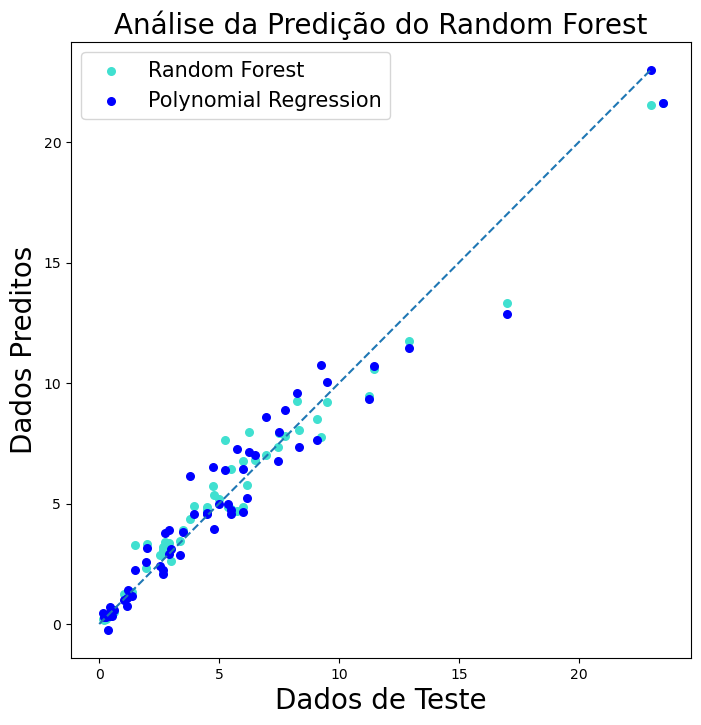

In [27]:
x_linha = np.arange(0,max(y_test))
y_linha = x_linha
    
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred_rf, s=30, color="turquoise", label="Random Forest")
plt.scatter(y_test, y_pred_poly, s=30, color="blue", label = "Polynomial Regression")
plt.plot(x_linha, y_linha, "--")
plt.title("Análise da Predição do Random Forest", fontsize=20)
plt.xlabel("Dados de Teste", fontsize = 20)
plt.ylabel("Dados Preditos", fontsize = 20)
plt.legend(fontsize=15)
plt.show()

Vemos que apesar de algumas variações quando os preços são maiores, os dados estão alinhados a reta, evidenciando uma boa predição, podemos também estudar os resíduos da regressão.

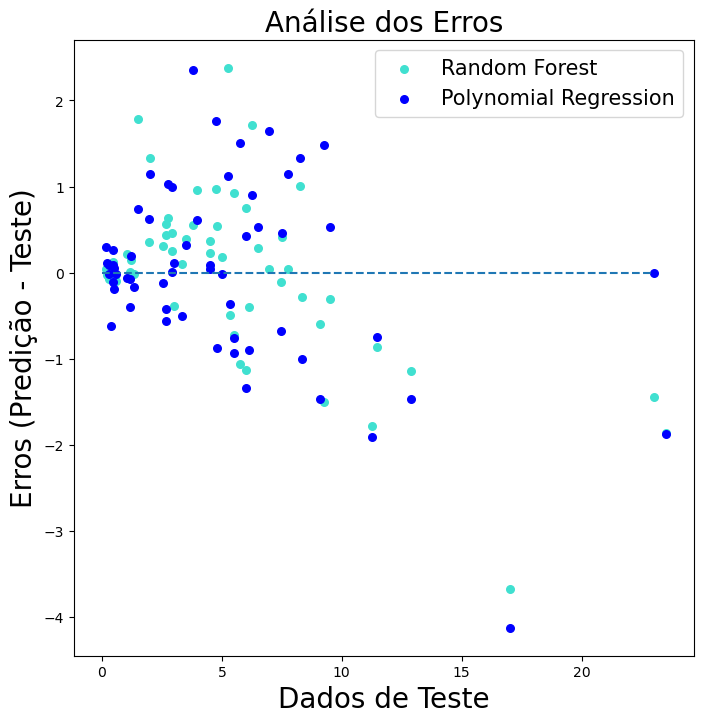

In [28]:
x_linha = np.arange(0,max(y_test))
y_linha = len(x_linha)*[0]
   
erro = y_pred_rf-y_test
erro2 = y_pred_poly-y_test

plt.figure(figsize=(8,8))
plt.scatter(y_test, erro, s=30, color="turquoise", label="Random Forest")
plt.scatter(y_test, erro2, s=30, color="blue", label = "Polynomial Regression")
plt.plot(x_linha, y_linha, "--")
plt.title("Análise dos Erros", fontsize=20)
plt.xlabel("Dados de Teste", fontsize = 20)
plt.ylabel("Erros (Predição - Teste)", fontsize = 20)
plt.legend(fontsize=15)
plt.show()

Vemos que o método de Regressão Polinomial é mais sensível aos valores maiores que o método Random Forest. Além disso, o erro para os dois modelos divergem com o aumento dos preços, isso pode indicar que ainda faltam informações para serem levadas em consideração na predição.

Uma forma de tentar aprimorar a predição é combinar os modelos, realizando médias ponderadas entre as predições.

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

rf = RandomForestRegressor(n_estimators=60, random_state=30)
poly_rg = PolynomialFeatures(degree=5)
ridge = Ridge()

x_poly = poly_rg.fit_transform(x_train)
x_poly_test = poly_rg.fit_transform(x_test)

model_rf = rf.fit(x_train,y_train)
model_poly = ridge.fit(x_poly, y_train)

y_pred_rf = model_rf.predict(x_test)
y_pred_poly = model_poly.predict(x_poly_test)

y_pred_mean = (y_pred_rf + y_pred_poly)/2
y_pred_mean_2 = (2*y_pred_rf + y_pred_poly)/3
y_pred_mean_3 = (y_pred_rf + y_pred_poly*2)/3

score_mean = r2_score(y_test, y_pred_mean)
score_mean_2 = r2_score(y_test, y_pred_mean_2)
score_mean_3 = r2_score(y_test, y_pred_mean_3)

print("Média",  score_mean)
print("Média Ponderada RF",  score_mean_2)
print("Média Ponderada Poly",  score_mean_3)



Média 0.9673180526218182
Média Ponderada RF 0.9679788346962553
Média Ponderada Poly 0.9650525038015626


Observamos que uma média ponderada, levando em consideração um peso de 2 para o modelo de Random Forest e peso de 1 para o modelo de Polynomial Regression ocasionou uma melhora
significativa no desempenho.

# Conclusão

Neste projeto realizamos todas as técnicas descritas em sala de aula para a elaboração de um modelo de regressão de dados. Passamos pelo processo de tratamento e exploração, etapa de seleção de modelos, ajustamos os mesmos e avaliamos seu erro. 

Chegamos à conclusão de que conseguimos sim prever preços de carros a partir de suas informações e aplicações dos métodos de ciẽncias de dados. Sendo estas previsões limitadas a $\approx 96,8 \% $ de variabilidade.

Algumas dificuldades encontradas foram os carros com preços acima da média, que apesar de serem considerados outliers, identificamos que suas informações são essenciais para a predição de carros com preços perto da média, desse modo, talvez um modelo mais robusto, ou a combinação de outros modelos poderiam auxiliar com o tratamento desses dados.

Além da predição, encontra-se neste documento uma plataforma para testar o modelo encontrado, com ela, podemos "pesquisar" preços de carros por meio de suas informações.

In [ ]:
df = df.drop(["Fuel_Type_Diesel", "Transmission_Automatic", "Seller_Type_Individual", "Usado"], axis=1)

df.to_csv("dados_plataforma.csv", index=False)